From the original full BindingDB database, we extracted a smaller, more manageable dataset by selecting only ligand-target pairs studied on viral organisms associated with sexually transmitted diseases, such as Human Immunodeficiency Virus (HIV). This subset is saved in the same `.tsv` file format as the original database.

For more details on the extraction process, refer to [`./src/data/std_extraction.ipynb`](./src/data/std_extraction.ipynb).


In [1]:
#import libraries and scripts

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import data_utils, evaluation_utils, general_utils

sns.set_palette('colorblind')



We import the reduced dataset, containing only viruses responsible for STDs as target organisms

In [2]:
#read the std database

df = pd.read_csv('BindingSTD.tsv', sep = '\t', on_bad_lines='skip', low_memory = False)
print(f'STDs dataset rows: {df.shape[0]}')
print(f'STDs dataset columns: {df.shape[1]}')

STDs dataset rows: 30156
STDs dataset columns: 194


In the dataset, four affinity metric are available:

1. **Ki (Inhibition Constant)**: Represents the concentration at which an inhibitor ligand occupies 50% of the receptor or enzyme sites, assuming no competing ligands are present. It quantifies the affinity of the inhibitor for the target under equilibrium conditions.

2. **IC50 (Half Maximal Inhibitory Concentration)**: Represents the concentration of a drug needed to inhibit a specific biological or biochemical function by 50%. It measures how much drug is required to achieve a halfway inhibition of the target activity in a given experimental setup.

3. **Kd (Dissociation Constant)**: Represents the concentration at which 50% of the binding sites on the target (e.g., receptor or enzyme) are occupied by the ligand. It quantifies the equilibrium affinity between a ligand and its target, with lower values indicating tighter binding.

4. **EC50 (Half Maximal Effective Concentration)**: Represents the concentration of a drug needed to produce 50% of its maximal effect in a biological system. It is an indicator of the drug's potency, reflecting the concentration required to achieve a halfway maximal response.

These metrics are interrelated but not directly interchangeable, although an approximate relationship between **Ki** and **IC50**, the Cheng-Prusoff equation, does exist. Unfortunately, strict conditions need to be satisfies, so we won't use it in our analysis.

Therefore, in the next cells we will select the most represented metric in our dataset and get rid of rows where it's not provided.

c:\Users\simon\Desktop\EPFL\ADA\TEAM\project_template\src\utils\evaluation_utils.py:65: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_matrix = overlap_matrix.applymap(lambda x: f"{x:.2f}%")


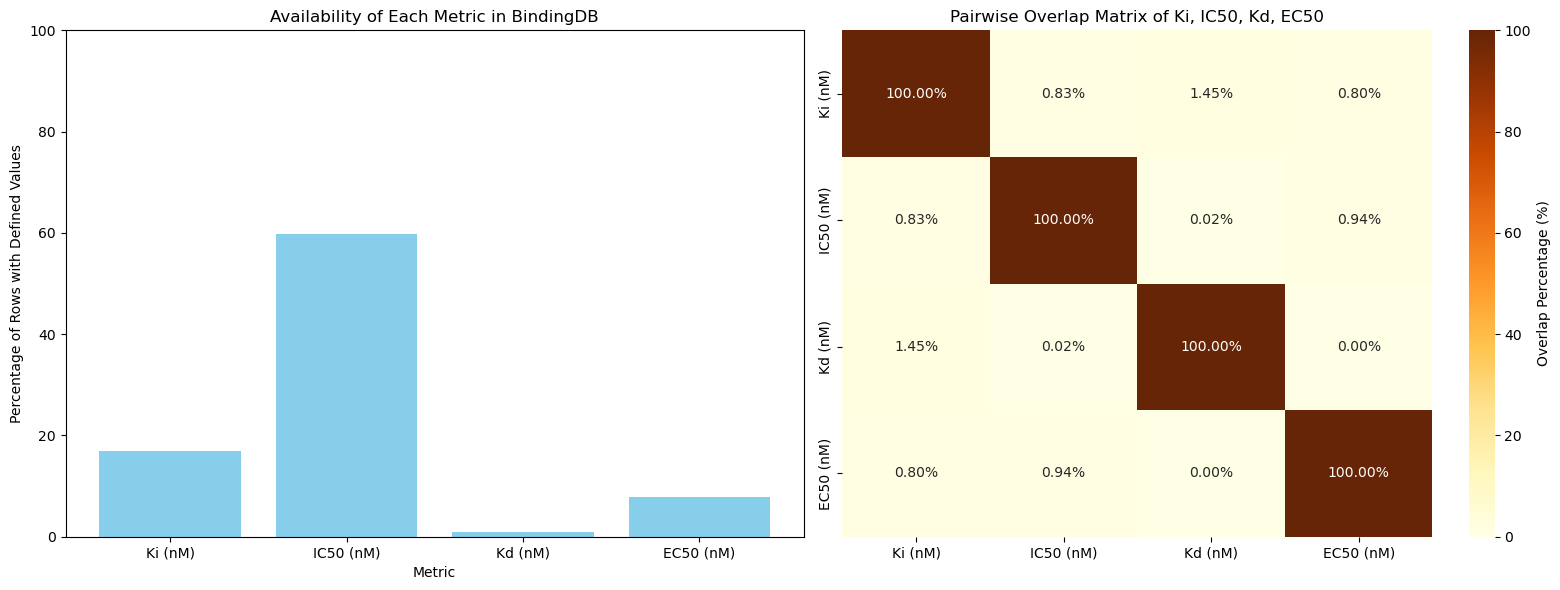

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax = axes.flatten()

evaluation_utils.plot_metric_availability(df, ax=ax[0])
evaluation_utils.plot_overlap_matrix(df, ax=ax[1])

plt.tight_layout()
plt.show()

We observe that IC50 is given in more than 50% of the rows, while the other metrics are less represented. In the overlap matrix, we also observe that metrics rarely overlap, so it makes sense to pick only one of the four for the analysis.  
In the next cell, we use the `data_utils.select_metric` function to select only rows with IC50 for our analyses.  
We also get rid of columns where more than 50% of entries are `NaN` through the `data_utils.clean_na_columns` function. Non-numeric entries that were not `NaN` (e.g., `'> 50000'`) were also removed, since they would negatively affect the computation of statistics like the mean.



In [6]:
df = data_utils.select_metric(df, 'IC50 (nM)')
df = data_utils.clean_na_columns(df)
print(f'Rows of STD dataset where IC50 is given: {df.shape[0]}')
print(f'Columns of STD dataset where nan rows are less than 50% of the total: {df.shape[1]}')

Rows of STD dataset where IC50 is given: 18026
Columns of STD dataset where nan rows are less than 50% of the total: 27


Now, we can try and observe the distribution of our IC50 parameter. Typically, IC50 values in the low nanomolar (nM) range, such as 1–100 nM, are considered very potent. The range of IC50 values can vary widely depending on the specific biological system, target, and experimental conditions.
Compounds with IC50 values in the 100 nM – 1 µM (1000 nM) range are moderately potent. Above 1 µM (1000 nM) are the drugs that are considered to have a lower affinity for their target. When we have very high IC50 values, in the range of several µM (micromolar) to mM (millimolar), the compound is considered not effective at binding its target and often must be optimized for potency.

In [6]:
df['IC50 (nM)'].describe()

count    1.802600e+04
mean     3.920599e+04
std      5.866093e+05
min      1.000000e-03
25%      3.500000e+01
50%      4.400000e+02
75%      5.900000e+03
max      3.815000e+07
Name: IC50 (nM), dtype: float64

<Axes: ylabel='IC50 (nM)'>

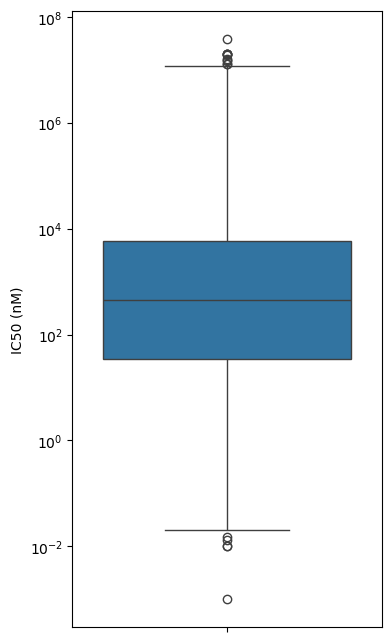

In [ ]:
# set the figure size
plt.figure(figsize=(4, 8))

### create the boxplot
sns.boxplot(y=df['IC50 (nM)'], log_scale=True)

We can see that our data spans a large range, therefore in order to be able to properly see the smaller values and show a more interpretable visualization we can use a logarithmic compression. This log-log transformation can reveal patterns across data that spans several orders of magnitude, both in terms of IC50 values (x-axis) and counts (y-axis).


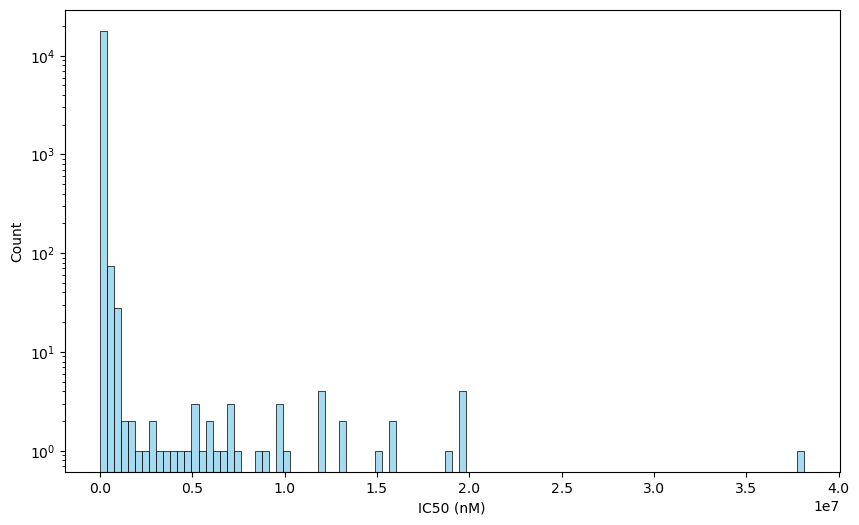

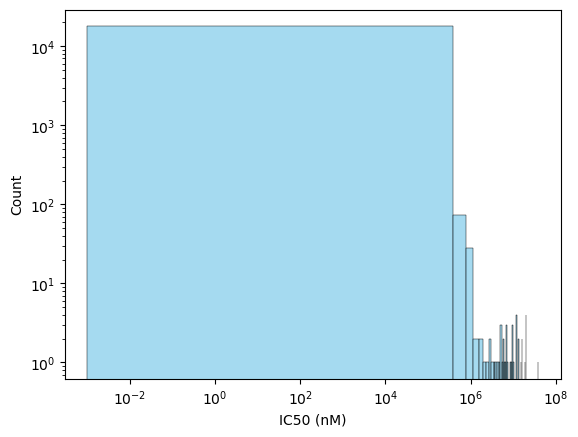

In [29]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create the histogram using Seaborn with a logarithmic scale
sns.histplot(df['IC50 (nM)'], bins=100, kde=False, color='skyblue')

# Set the y-axis only to a logarithmic scale
#plt.xscale('log')
plt.yscale('log')
plt.show()

#Set both x-axis and y-axis to a logarithmic scale (bins = 100 instructs the histogram to split the data in 100 equally spaced bins,
# regarding the range of our parameter. 
# We will have smaller bins as we go towards the right, as larger numbers will be more compressed)
sns.histplot(df['IC50 (nM)'], bins=100, kde=False, color='skyblue')
plt.xscale('log')
plt.yscale('log')

In [ ]:
###let's see how STDs are distributed 
def plot_organism_counts(STD_df):
    # Count the number of occurrences for each type of disease
    organism_counts = STD_df['Target Source Organism According to Curator or DataSource'].value_counts().reset_index()
    organism_counts.columns = ['Target Source Organism According to Curator or DataSource', 'Count']

    plt.figure(figsize=(12, 12))

    # Create the bar plot with the pastel color palette
    sns.barplot(
        x='Target Source Organism According to Curator or DataSource', y='Count', data=organism_counts, palette="pastel"
    )

    plt.xticks(rotation=90, ha='right')
    plt.xlabel('Target Source Organism According to Curator or DataSource')
    plt.ylabel('Number of Rows')
    plt.title('Number of Rows per Target Source Organism')
    plt.tight_layout()
    plt.show()


# Assuming STD_df is the DataFrame containing the relevant data
plot_organism_counts(df)